<a href="https://colab.research.google.com/github/maxmatical/fast.ai/blob/master/Numpy_ML_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks (and logistic regression)
https://quantdare.com/create-your-own-deep-learning-framework-using-numpy/

In [ ]:
from abc import ABC, abstractmethod
from typing import List, Optional, Tuple
from enum import Enum, auto
import numpy as np


In [ ]:
# A
a =[0, 0, 1, 1, 0, 0,
   0, 1, 0, 0, 1, 0,
   1, 1, 1, 1, 1, 1,
   1, 0, 0, 0, 0, 1,
   1, 0, 0, 0, 0, 1]
# B
b =[0, 1, 1, 1, 1, 0,
   0, 1, 0, 0, 1, 0,
   0, 1, 1, 1, 1, 0,
   0, 1, 0, 0, 1, 0,
   0, 1, 1, 1, 1, 0]
# C
c =[0, 1, 1, 1, 1, 0,
   0, 1, 0, 0, 0, 0,
   0, 1, 0, 0, 0, 0,
   0, 1, 0, 0, 0, 0,
   0, 1, 1, 1, 1, 0]

# Creating labels
# y =[[1, 0, 0],
#    [0, 1, 0],
#    [0, 0, 1]]

y = [1,2,3]

In [ ]:
x =np.array([a, b, c])
  
  
# Labels are also converted into NumPy array
y = np.array(y)
  
  
print(x, "\n\n", y)

[[0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1]
 [0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0]
 [0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0]] 

 [1 2 3]


**Make sure `y` is (n, 1)!!!**


In [ ]:
x.shape, y.shape

((3, 30), (3,))

In [ ]:
# abstract class
class Layer(ABC):

    @abstractmethod
    def forward(self, input):
        pass

    @abstractmethod
    def backward(self, input):
        pass


class LayerType(Enum):
    # to keep track of layer types in NN
    # layer type determines what is returned in the backward pass
    linear = auto()
    relu = auto()
    sigmoid = auto()


In [ ]:
# linear layer
class Linear(Layer):
    def __init__(self, in_dim: int, out_dim: int):
        self.weights = np.random.normal(size=(in_dim, out_dim)) 
        self.biases = np.random.rand(1, out_dim)
        # keep track of layer type for computing gradients
        self.type = "linear"

    def forward(self, input: np.ndarray) -> np.ndarray:
        """
        output is n_row x out_dim
        # input into the layer is activations from previous layer
        # keep track of previous activations for back prop
        """
        self.prev_activations = input 
        return np.matmul(input, self.weights) + self.biases

    def backward(self, dA: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        dA is shape (n_row, out_dim)

        by chain rule, dW is just equals to dA dot product with previous activations
        dW is shape (in_dim, out_dim)
        so need to do (in_dim, n_rows)@(n_row, out_dim) -> transpose acts

        dB is shape (1, out_dim)

        error should be shape (n_row, in_dim) -> (n_row, out_dim) @ (out_dim, in_dim)
        """
        n_row, out_dim = dA.shape[0], dA.shape[1]
        dW = np.dot(self.prev_activations.T, dA) 
        dB = dA.mean(axis=0, keepdims=True) # average across rows (where dim = 0) to get dB
        assert dB.shape == (1, out_dim)
        # error = np.dot(self.weights, dA.T) 
        error = np.dot(dA, self.weights.T) # propagate error backwords by multiplying dA by weights
        # print("linear error shape", error.shape)
        return error, dW, dB

    def update(self, dW: np.ndarray, dB: np.ndarray, lr: float):
        # update the weights and biases given gradients and lr
        self.weights -= lr * dW
        self.biases -= lr * dB


In [ ]:
l = Linear(30, 4)
pred = l.forward(x)
pred

array([[-1.60224555,  8.00845447,  2.41411131,  5.23822594],
       [ 0.36815769,  2.46644677,  6.74448148,  5.19347536],
       [-1.4326639 ,  1.3993949 ,  6.57858832,  1.8957478 ]])

In [ ]:
pred.mean(axis=0, keepdims=True) # since pred has same shape as dA, use to test

array([[-0.88891725,  3.95809871,  5.24572703,  4.1091497 ]])

In [ ]:
# activations
class ReLU(Layer):
    def __init__(self):
        # keep track of layer type for computing gradients
        self.type = "relu"
    

    def forward(self, input: np.ndarray) -> np.ndarray:
        # keep track of activations for backprop
        self.activations = np.maximum(0, input) 
        return self.activations


    def backward(self, error: np.ndarray) -> np.ndarray:
        """
        gradient of relu is 1 if self.activation > 0, 0 otherwise

        # gradients = np.copy(self.activations)
        # gradients[self.activations > 0] = 1
        # gradients[self.activations <= 0] = 0
        # return error * gradients

        alternatively, use heaviside function

        activations is (row, out_dim)
        so error should be (row, out_dim)

        """
        # print("relu error shape", error.shape)
        return error * np.heaviside(self.activations, 0)
        

class Sigmoid(Layer):
    def __init__(self):
        # keep track of layer type for computing gradients
        self.type = "sigmoid"


    def forward(self, input: np.ndarray) -> np.ndarray:
        # keep track of activations for gradient calc in backward pass
        self.activations = 1/(1 + np.exp(-input))
        return self.activations


    def backward(self, error: np.ndarray) -> np.ndarray:
        """
        derivative of sigmoid function is sig*(1-sig)
        note error, activations, and output shape are the same size

        activations is (row, out_dim)
        so error should be (row, out_dim) and output is (row, out_dim)
        """
        sig = self.activations
        out = error * sig * (1 - sig)
        return error * sig * (1 - sig)


class Softmax(Layer):
    def __init__(self):
        self.type = "softmax"
    
    def forward(self, input: np.ndarray) -> np.ndarray:
        """        
        # keep track of activations for gradient calc in backward pass
        # e^x/sum(e^x)

        alternatively: for large numbers, use np.exp(input-np.max(input))
        for numerical stability
        """
        exp = np.exp(input)
        self.activations = exp/np.sum(exp)
        return self.activations

    def backward(self, error: np.ndarray) -> np.ndarray:
        """
        derivative of softmax (for a vector) is 

        https://stackoverflow.com/a/40576872
        if i == j:
            gradients[i, j] = self.activations[i]*(1-self.activations[i])
        else:
            gradients[i, j] = -self.activations[i] * self.activations[j]

        then return error * gradients

        note error, activations, and output shape are the same size

        alternatively:

        SM = self.activations.reshape((-1,1))
        jac = np.diagflat(self.activations) - np.dot(SM, SM.T)
        return error * jac
        """
        #initialize matrix same shape as error matrix
        gradients = np.zeros(self.activations.shape) 
        for i in range(self.activations.shape[0]):
            for j in range(self.activations.shape[1]):
                if i == j:
                    gradients[i, j] = self.activations[i, i]*(1-self.activations[i, i])
                else:
                    gradients[i, j] = -self.activations[i, i] * self.activations[i, j]
                """
                self.activation[i, i] since i=th row

                """
        return error * gradients

    

In [ ]:
relu = ReLU()
relu.forward(pred).shape, relu.backward(pred).shape

((3, 4), (3, 4))

In [ ]:
sig = Sigmoid()
sig.forward(pred).shape, sig.backward(pred).shape

((3, 4), (3, 4))

In [ ]:
softmax = Softmax()
softmax.forward(pred).shape, softmax.backward(pred).shape

((3, 4), (3, 4))

derivative of BCE loss


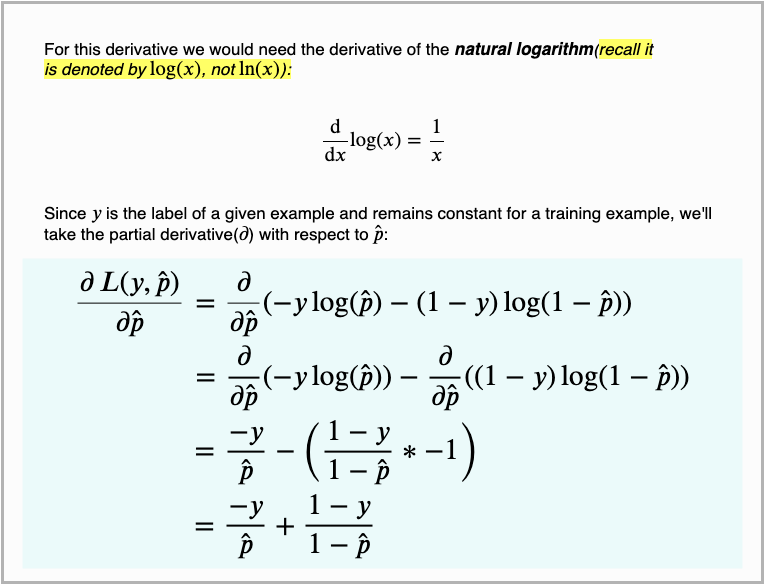


In [ ]:
# loss functions
class LossType(Enum):
    mse = auto()
    bce = auto()


class MSE(Layer):
    def __init__(self, pred, y):
        self.pred = pred
        self.y = y
        assert self.pred.shape == self.y.shape, "error, shape mismatch between pred and y"

    def forward(self) -> float:
        return np.power(self.pred - self.y, 2).mean()


    def backward(self) -> np.ndarray:
        # shape is (n_row, out_dim)
        # need to keep same dimensions as pred and y
        # to get loss wrt to each output
        # since the 2 is a constant factor, we can leave out
        # (equivalent to multiplying lr by 2)
        return self.pred - self.y


class BCE(Layer):
    def __init__(self, pred, y):
        self.pred = pred
        self.y = y
        self.n = len(self.y)
        assert self.pred.shape == self.y.shape, "error, shape mismatch between pred and y"


    def forward(self) -> float:
        loss = np.nansum(-self.y * np.log(self.pred) - (1 - self.y) * np.log(1 - self.pred)) / self.n
        # loss and np.squeeze(loss) should be the same
        return np.squeeze(loss) 


    def backward(self) -> np.ndarray:
        # return shape is (n_row, out_dim)
        return (-(self.y / self.pred) + ((1 - self.y) / (1 - self.pred))) / self.n

In [ ]:
mse = MSE(y+5, y)
mse.backward()

array([5, 5, 5])

In [ ]:
bce = BCE(y+5, y)
bce.forward()
bce.backward()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log


array([-0.05555556, -0.03968254, -0.0297619 ])

In [ ]:
class Model:
    def __init__(self, in_dim: int, layers: Optional[List[int]], out_dim: int, loss_fn: str):
        self.in_dim = in_dim # get input dimension for matmul, = X.shape[1]
        self.layers=[]
        self.loss_fn = loss_fn
        assert self.loss_fn in [l.name for l in LossType], f"error, loss {self.loss_fn} not recognized"

        if layers:
            """if layers not given, is equivalent to linear/logistic regression
            """
            for l in layers:
                # each layer is a feedforward + relu
                self.layers.append(Linear(self.in_dim, l))
                self.layers.append(ReLU())
                self.in_dim = l
        # add final classifier layer + activation
        self.layers.append(Linear(self.in_dim, out_dim))
        # final_act_fn = Identity() if self.loss_fn == LossType.mse.name else Sigmoid()
        # self.layers.append(final_act_fn)
        if self.loss_fn == LossType.bce.name:
            self.layers.append(Sigmoid())



    def forward(self, input: np.ndarray) -> np.ndarray:
        for l in self.layers:
            input = l.forward(input)
        return input
        

    def backward(self, pred: np.ndarray, y: np.ndarray, lr: float):
        loss_func = MSE(pred, y) if self.loss_fn == LossType.mse.name else BCE(pred, y)
        loss = loss_func.forward()
        # compute gradients
        gradient = loss_func.backward()

        # backprop through the layers:
        for i, l in reversed(list(enumerate(self.layers))):
            if l.type != LayerType.linear.name:
                # if not linear layer, just calculate the gradient and 
                # pass to the previous layer
                gradient = self.layers[i].backward(gradient)
            else:
                gradient, dW, dB = self.layers[i].backward(gradient)
                self.layers[i].update(dW, dB, lr)
        return loss # keep track of loss


    def fit(self, input: np.ndarray, y: np.ndarray, n_epochs: int, lr: float):
        for _ in range(n_epochs):
            out = self.forward(input)
            loss = self.backward(out, y, lr)
            print(f"loss {self.loss_fn} = {loss}")


In [ ]:
nn = Model(in_dim=30, layers = [4,5,6], out_dim = 1, loss_fn="mse")
out = nn.forward(x)
out

array([[-0.98813086],
       [-0.98813086],
       [-0.98813086]])

In [ ]:
y = y.reshape(-1, 1) # reshape y to match pred.shape aka (rows, 1)

In [ ]:
out.shape, y.shape

((3, 1), (3, 1))

In [ ]:
nn.backward(out, y, lr=0.001)

9.59559267854637

In [ ]:
nn.fit(x, y, n_epochs=10, lr=0.001)

loss mse = 9.328794059684448
loss mse = 9.070584089558691
loss mse = 8.820636147502897
loss mse = 8.578639361758258
loss mse = 8.34429766277912
loss mse = 8.117328903285243
loss mse = 7.897464039748857
loss mse = 7.684446370475576
loss mse = 7.47803082586245
loss mse = 7.277983306799958


In [ ]:
"""
linear/logistic regression is equivalent to MLP
just without any hidden layers
"""
log_reg = Model(in_dim=30, layers = None, out_dim = 1, loss_fn="bce")
log_reg.fit(x, y, n_epochs=10, lr=0.001)

loss bce = 5.943150344205013
loss bce = 5.9032142035089485
loss bce = 5.8633151758108975
loss bce = 5.823453901849782
loss bce = 5.783631030785172
loss bce = 5.743847220206206
loss bce = 5.7041031361361485
loss bce = 5.664399453032353
loss bce = 5.624736853781546
loss bce = 5.5851160296901625


# Decision Tree/ Random Forests

https://forums.fast.ai/t/unofficial-lesson-7-classnotes/7955

# KNN

In [ ]:
class KNN:
    def __init__(self, k = 1):
        self.k = k

    def fit(self, x, y):
        """Train the classifier (here simply save training data)

        x -- feature vectors (N x D)
        y -- labels (N x 1)
        """
        self.x_train = x
        self.y_train = y
        self.n_classes = np.amax(self.y_train)+1 # labels go from 0,..,n, so add +1

    @staticmethod 
    def calculate_distance(x1, x2):
        """
        calculate the euclidian distance
        = sqrt(sum( (x1 - x2)^2 ))
        """
        return np.sqrt(np.sum(np.square(x1-x2), axis=1))

    def predict(self, x_test):
        """
        loop over all x_test
        calculate array of euclidian distance between x_train and x
        get y for the topk neighbors
        get the argmax value (aka class with most counts)
        append to preds

        """
        preds = []
        for x in x_test:
            dist = self.calculate_distance(self.x_train, x_test)
            # keep count of y_preds
            y_pred_counts = np.zeros(self.n_classes, dtype=np.int)

            # find k closest neighbors
            # use argsort to return the indices of that sorted array
            # and take top k of the arg sort array
            for neighbor_id in np.argsort(dist)[:self.k]:
                # get the y value of that neighbor
                neighbor_y = self.y_train[neighbor_id]
                # add to y_pred_counts
                y_pred_counts[neighbor_y] += 1

                preds.append(np.argmax(y_pred_counts))

        return preds




# SVM
https://www.python-engineer.com/courses/mlfromscratch/07_svm/?fbclid=IwAR2N_pwNT50cl7x3qW7RF5uhXgbSVL_H6BKqmNTv8iciJbtvYKN24ShDA28

https://medium.com/@saishruthi.tn/support-vector-machine-using-numpy-846f83f4183d

**Alternatively** think of SVM as a NN with hinge loss and L1 regularization
 - maximum margin hyperplane is just hinge loss + L1 regularization
 - take `sign(pred)` asfinal prediction

https://twitter.com/jeremyphoward/status/1215875259364102144?s=09&fbclid=IwAR1Vbq0WjO53tzmwywZ0zVgB5_XtiCCDtDfkMpqEEJG6SAitreY8BTJPEh0

note svm update function is

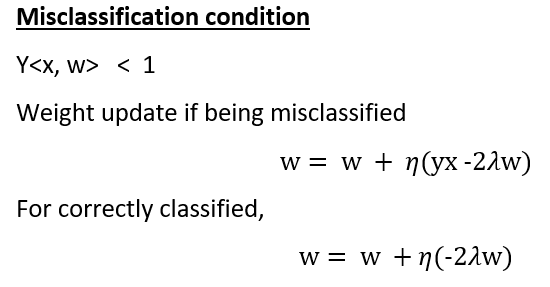

In [ ]:
## NN style
class HingeLoss(Layer):
    """
    https://discuss.pytorch.org/t/is-there-standard-hinge-loss-in-pytorch/5590/5
    """
    def __init__(self, pred: np.ndarray, y: np.ndarray):
        self.pred = pred
        self.y = y
        assert self.pred.shape == self.y.shape, "error, shape mismatch between pred and y"


    def forward(self) -> float:
        """
        loss is max(0, 1- y*pred)

        where y = {-1, 1}
        """
        self.loss = 1-np.multiply(pred, y)
        self.loss[self.loss < 0 ] = 0 
        return self.loss.mean()


    def backward(self) -> np.ndarray:
        """
        derivative of 1-y*pred wrt pred = -y
        multiply that by heaviside function since max(0, 1-y*pred)
        """
        return np.multiply(np.heaviside(self.loss, 0), self.y)

In [ ]:
y = np.array([-1, 1, 1, -1])
pred = np.array([-0.5, 0.5, -0.5, -1.5])
l = HingeLoss(pred, y)


In [ ]:
l.forward()

0.625

In [ ]:
l.backward()

array([-1.,  1.,  1., -0.])

In [ ]:
# SVM class (in NN style)

class SVM:
    def __init__(self, in_dim:int, gamma: float = 0.01):
        self.gamma = gamma # regularizing param
        self.in_dim = in_dim

        # initialize weights and biases
        self.w = np.random.normal(size=(self.in_dim, 1))
        self.b = np.random.rand(1, 1)

    def forward(self, input: np.ndarray) -> np.ndarray:
        """
        self.w  needs to be (n_col, 1)
        so np.matmul(x, self.w) is shape (n_row, n_col)*(n_col, 1) => (n_row, 1)
        """
        self.previous_activations = input # keep track of previous activations
        n_rows, n_cols = input.shape[0], input.shape[1]
        assert n_cols == self.in_dim, "dimension mismatch, input n_cols does not match in_dim"
        # print(input.shape, self.w.shape)
        # print(np.matmul(input, self.w).shape)
        return np.matmul(input, self.w) - self.b

    def backward(self, pred: np.ndarray, y: np.ndarray, lr: float):
        loss_func = HingeLoss(pred, y)
        loss = loss_func.forward()
        # compute gradients
        gradient = loss_func.backward()
        dW = np.dot(self.previous_activations.T, gradient)
        # print("gradient shape", gradient.shape)
        # print("dW shape", dW.shape)

        # update values of self.w and self.b
        # similar to NN, self.activations for self.w is just x
        self.w -= lr*(dW-2*self.gamma*self.w)
        """
        for dB, dB = dA.mean(axis=1, keepdims=True)
        dA is the incoming error, which is just error
        """
        dB = gradient.mean(axis=0, keepdims=True)
        # print("dB shape", dB.shape)
        self.b -= lr*dB


    def fit(self, x: np.ndarray, y: np.ndarray, n_epochs: int, lr: float):
        for _ in range(n_epochs):
            pred = self.forward(x)
            self.backward(pred, y, lr)

    def predict(self, x_test: np.ndarray, return_class: bool = True):
        preds = np.matmul(x_test, self.w) - self.b
        return np.sign(preds) if return_class else preds


In [ ]:
svm = SVM(in_dim = 30)
y = np.array([-1, 1, 1]).reshape(-1,1) # make sure it's reshaped!!!
print(y.shape)
pred = svm.forward(x)
pred

(3, 1)


array([[6.31374379],
       [3.69875184],
       [4.62464398]])

In [ ]:
l = HingeLoss(pred, y.reshape(-1,1))
l.forward()

2.437914596258581

In [ ]:
l.loss

array([[7.31374379],
       [0.        ],
       [0.        ]])

In [ ]:
svm.backward(pred, y, lr=1)

In [ ]:
svm.fit(x, y, 10, 0.01)

In [ ]:
svm.predict(x)

array([[1.],
       [1.],
       [1.]])

# K means 

https://blog.paperspace.com/speed-up-kmeans-numpy-vectorization-broadcasting-profiling/